In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks

In [145]:
input_data = "../data/processed/ecg-id-database-1.0.0/Person_01_rec_1.csv"
# input_data = "../data/processed/ecg-id-database-1.0.0/Person_34_rec_2.csv"
# input_data = "../data/processed/ecg-id-database-1.0.0/Person_01_rec_12.csv"

with open(input_data, "r") as in_data:
    full_dataset = pd.read_csv(in_data)

In [146]:
ecg_data = full_dataset['ECG_I_filtered'].values
ecg_data = pd.Series(ecg_data)

### Finding R waves in a small ECG chunk

<Axes: >

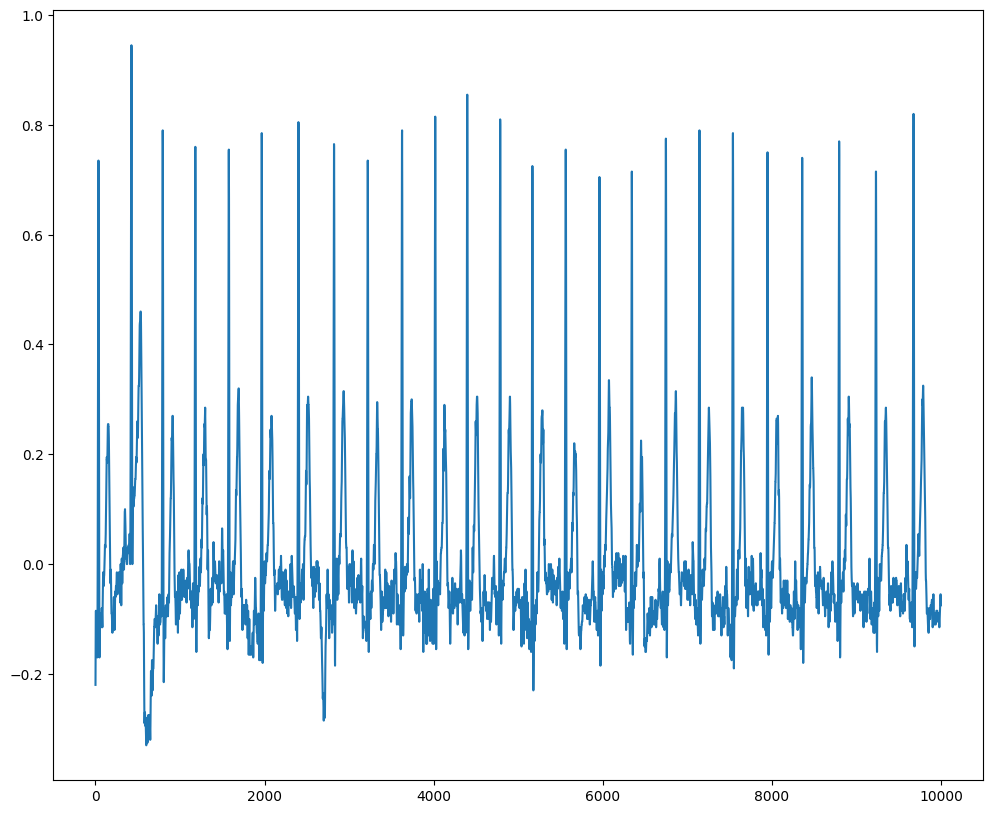

In [147]:
plt.figure(figsize=(12, 10))
ecg_data.plot()

Text(0.5, 1.0, '15 Seconds of ECG')

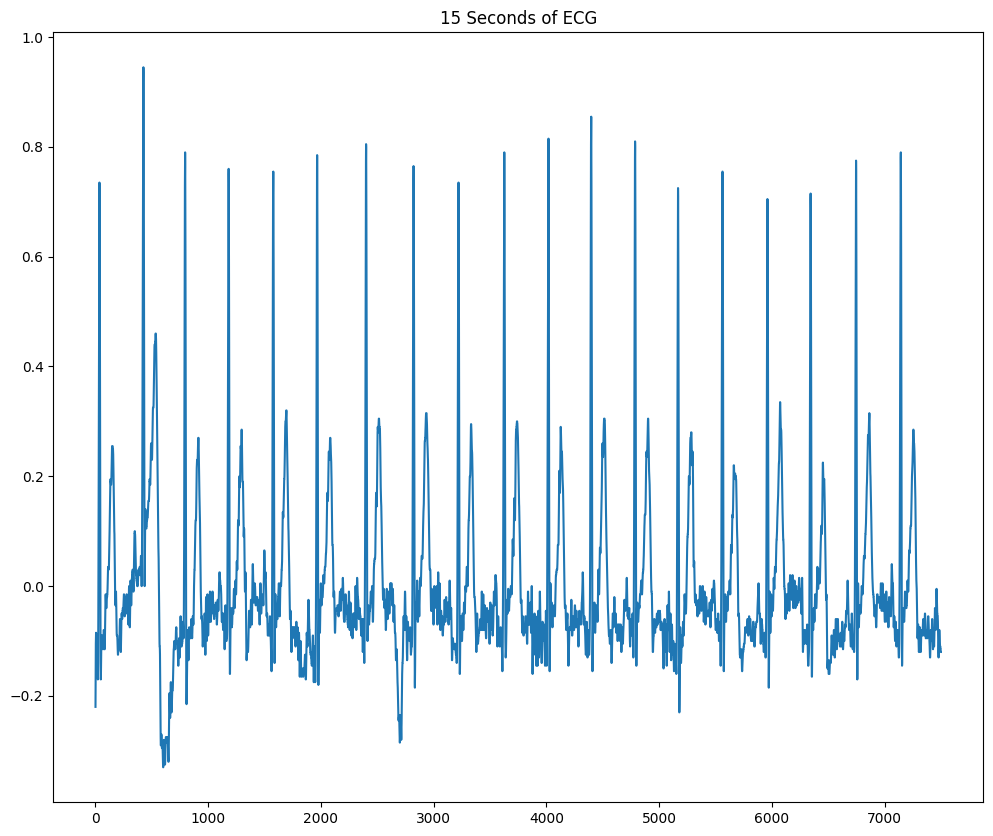

In [148]:
ecg_15_seconds = ecg_data[:7500]

plt.figure(figsize=(12, 10))
ecg_15_seconds.plot()
plt.title("15 Seconds of ECG")

Text(0.5, 1.0, 'Weird R-R')

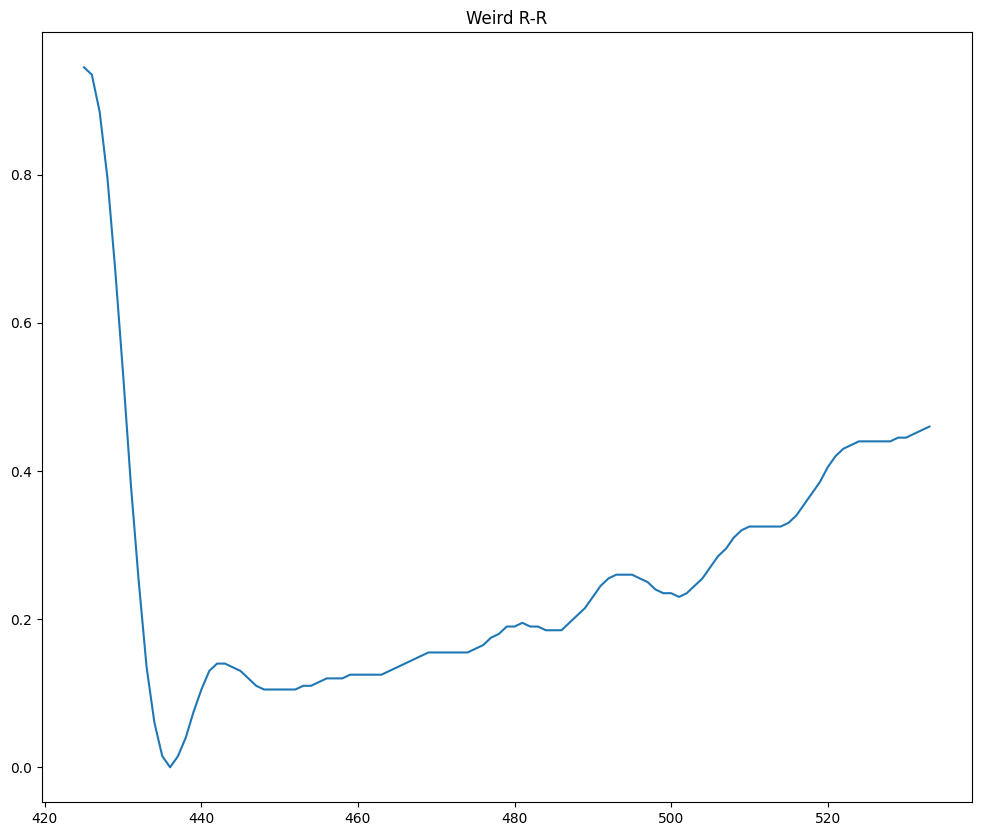

In [152]:
rr_weird = ecg_data[425:534]

plt.figure(figsize=(12, 10))
rr_weird.plot()
# plt.yticks(np.arange(-0.4, 0.8, 0.05))
# plt.xticks(np.arange(5200, 5550, 25))
plt.title("Weird R-R")

In [155]:
peaks, _ = scipy.signal.find_peaks(ecg_15_seconds, height=0.45)
peaks = peaks + 0
peaks

array([  35,  425,  795, 1181, 1577, 1966, 2400, 2821, 3220, 3626, 4018,
       4397, 4786, 5167, 5561, 5960, 6343, 6746, 7143])

Text(0.5, 1.0, '15 Seconds ECG With R waves Labeled')

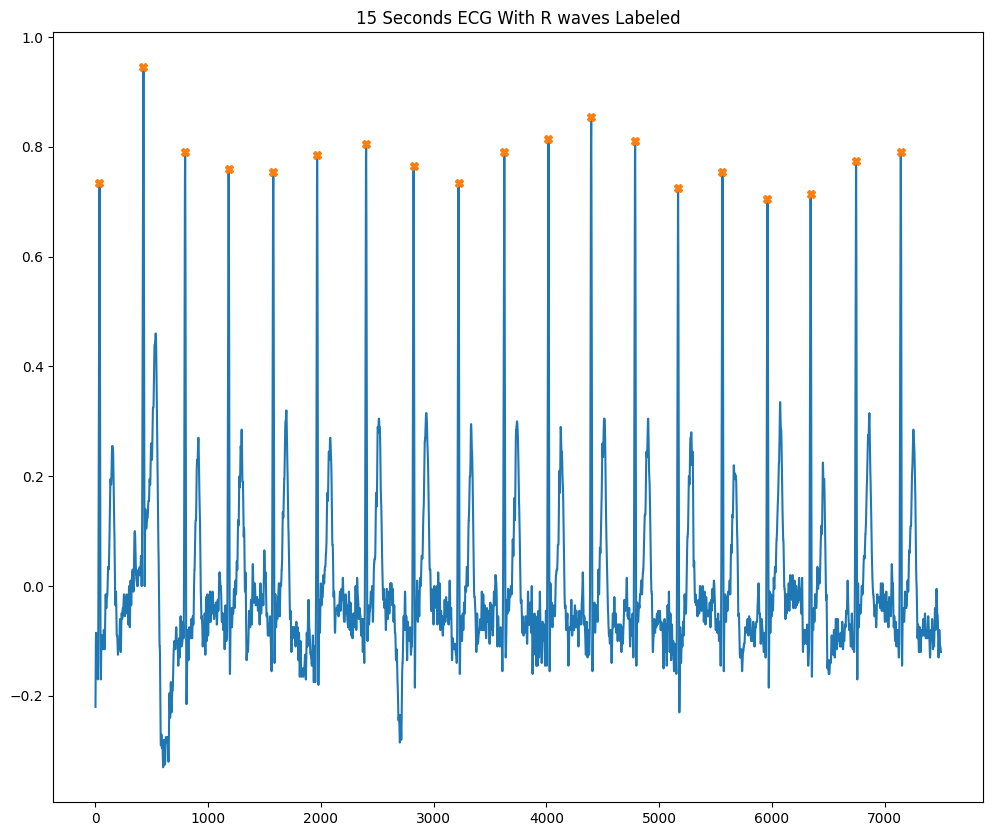

In [156]:
plt.figure(figsize=(12, 10))

ecg_15_seconds.plot()
plt.plot(peaks, ecg_15_seconds[peaks], "X")
plt.title("15 Seconds ECG With R waves Labeled")

### Making sure peaks are not falsely marked

In the graph above, some data points that are above the threshold are falsely marked as R waves. We can tell SciPy to only mark peaks that are a certain distance apart horizontally, since R waves can only happen so closely together.

The theoretical limit for heart rate in humans is 300 bpm, though there is also evidence of heart rates of 480 bpm and 600 bpm in rare medical cases. At this extreme upper limit of 600 bpm, that would mean that the fastest human heart rate every would happen 10 times per second. For our dataset, which has 360 data points per second (360 Hz), the fastest human heart rate would have peaks at most every 36 data points (360 Hz / 10 beats per second). Therefor, we can tell SciPy to only capture R wave peaks every 36 data points apart and still capture extreme medical anomalies.

We'll use distance=36 to tell SciPy the minimum distance R waves must be from each other.


In [73]:
peaks, _ = scipy.signal.find_peaks(ecg_15_seconds, height=0.45, distance=36)
peaks = peaks + 0
peaks

array([150])

Text(0.5, 1.0, '15 Seconds ECG With R waves Labeled')

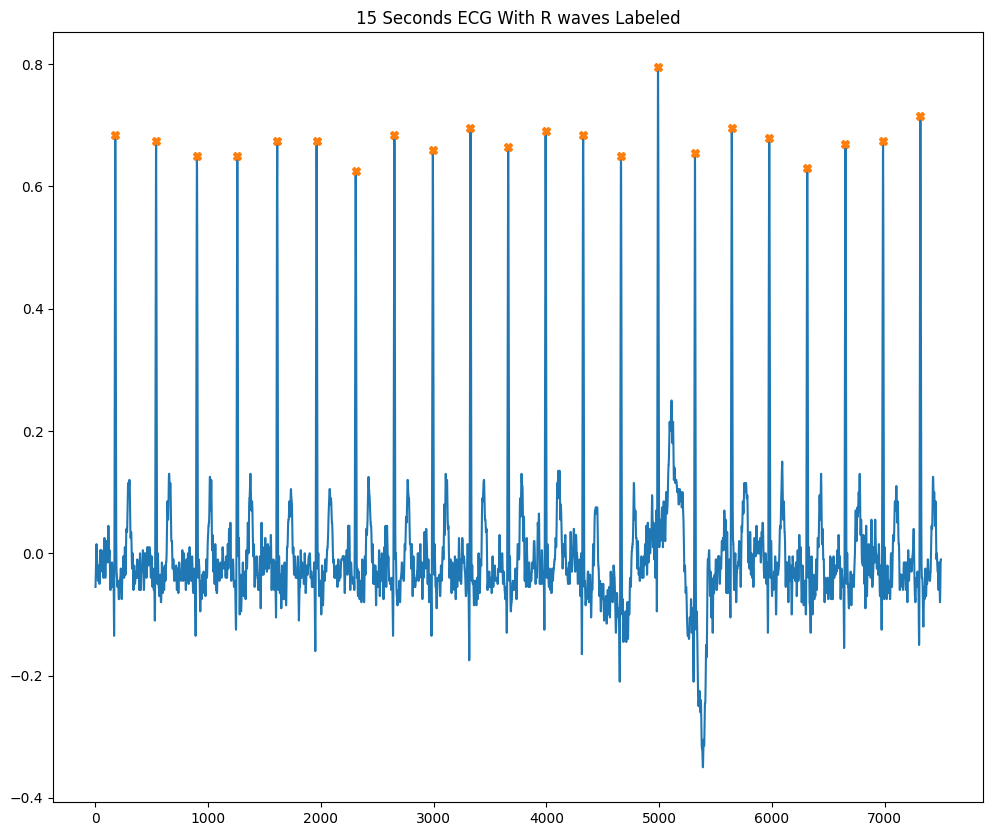

In [42]:
plt.figure(figsize=(12, 10))

ecg_15_seconds.plot()
plt.plot(peaks, ecg_15_seconds[peaks], "X")
plt.title("15 Seconds ECG With R waves Labeled")

## Measuring the Heart Rate

Heart rate is typically measured in 6-10 second chunks then multiplied to get the beats per minute. We can do this with our ECG data by counting the number of R waves in a 6-10 second chunk, since R waves are heartbeats.

For example, if there are 12 R waves in our 10-second chunk of the EKG, then we multiply the heart rate (12) by the number of 10-second chunks in a minute (6) to get our BPM. 12 heartbeats * 6 = 72 bpm. On the corollary, if we take a 6-second chunk, we'll multiply the heart beats by 10 so that the full count is calculated for 60 seconds.

We don't want to choose too large of a chunk to calculate the heart rate (a minute, for example), since heart rate can change rapidly in a medical setting. Rapid changes need to be seen and alerted on in seconds.

Text(0.5, 1.0, '6 seconds of ECG data')

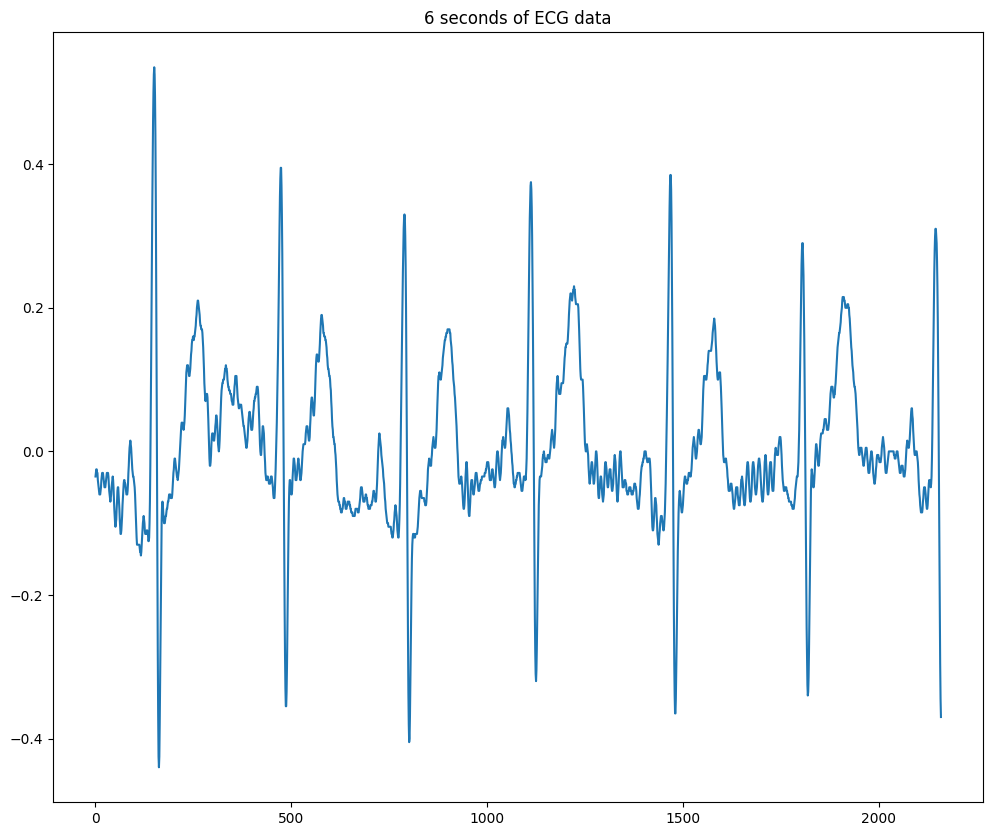

In [102]:
six_seconds_end_index = 6 * 360

plt.figure(figsize=(12, 10))
ecg_6_seconds = ecg_data[: + six_seconds_end_index]
ecg_6_seconds.plot()
plt.title("6 seconds of ECG data")

In [103]:
peaks, _ = scipy.signal.find_peaks(ecg_6_seconds, height=0.275, distance=36)
peaks = peaks + 0 # Adjust index to start at 0, the same as `ecg_6_seconds`
peaks

array([ 150,  473,  789, 1112, 1468, 1805, 2145])

In [104]:
heart_rate = len(peaks) * 10
heart_rate

70

Text(0.5, 1.0, '6-second EKG with R waves labeled')

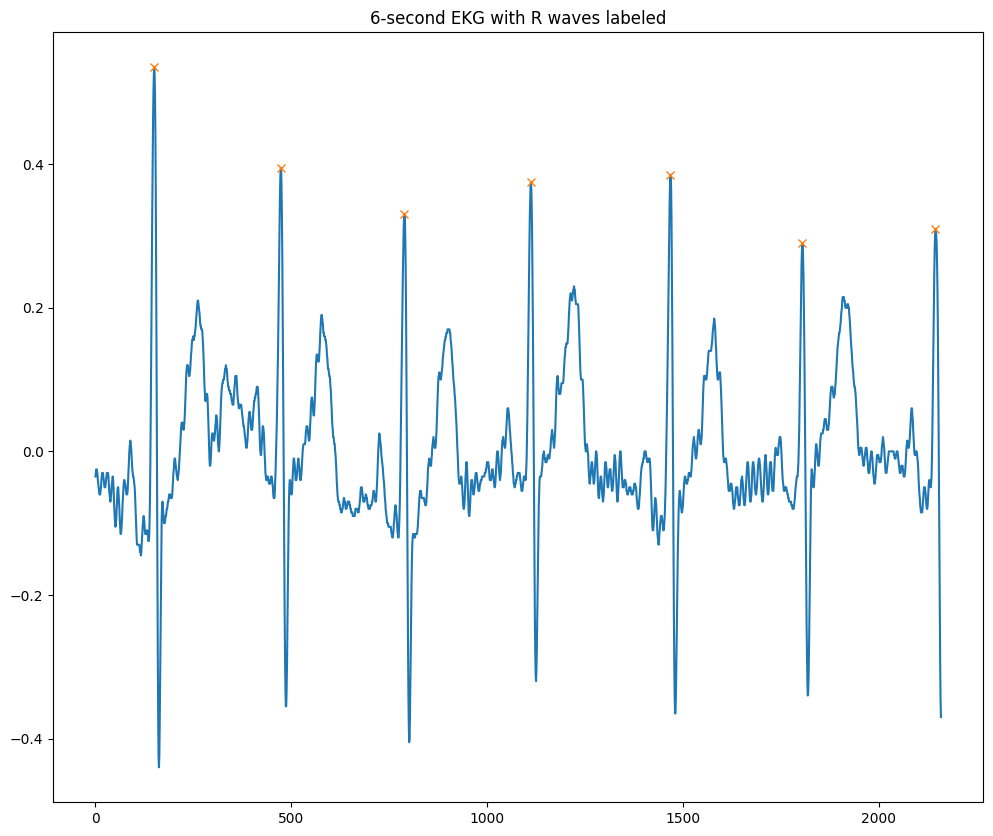

In [105]:
plt.figure(figsize=(12, 10))
ecg_6_seconds.plot()
plt.plot(peaks, ecg_6_seconds[peaks], "x")
plt.title("6-second EKG with R waves labeled")

# Full Dataset

In [137]:
smoothed_heartbeats = scipy.signal.savgol_filter(ecg_data, window_length=20, polyorder=2)

In [138]:
# Find the R waves' peaks
r_waves, metadata = scipy.signal.find_peaks(ecg_data, height=0.275)

In [139]:
p_waves = []
q_waves = []
s_waves = []
t_waves = []

waves_list = []

In [140]:
index_range = len(smoothed_heartbeats) - 1 # helps us not overshoot last element's index
r_waves_indexed = enumerate(r_waves)       # adds a separate index number to each R wave

# Create a DataFrame to store labeled waves
waves_df = pd.DataFrame(columns=['time', 'p', 'q', 'r', 's', 't'])

In [141]:
# Total time duration (in seconds)
total_duration = 20

# Total number of data points
total_data_points = 10000

# Calculate the time increment per data point
time_increment = total_duration / total_data_points

# Time values based on the index
time_values = np.arange(len(ecg_data)) * time_increment

In [142]:
# Loop through the RR intervals
for (index, r) in r_waves_indexed:
    # Get the RR interval
    start_index = r                    # the index of the current R wave
    try:
        end_index = r_waves[index + 1] # the index of the next R wave
    except IndexError:
        end_index = index_range        # have hit the end of the heartbeat array
    temp_rr_interval = smoothed_heartbeats[start_index:end_index]

    # Label the P and T waves
    p_and_t_waves, metadata = scipy.signal.find_peaks(temp_rr_interval,
                                                      height=[-0.1, 0.325],
                                                      distance=200)
    if not p_and_t_waves.any():
        p_wave = t_wave = None
    else:
        p_wave = p_and_t_waves[-1]
        t_wave = p_and_t_waves[0]

        p_wave += r
        t_wave += r
        
    # Label the Q wave
    q_area = temp_rr_interval[-16:]
    q_area = pd.Series(q_area)
    q_wave = q_area.idxmin(axis=0)

    # Label the S wave
    s_area = temp_rr_interval[0:16]
    s_area = pd.Series(s_area)
    s_wave = s_area.idxmin(axis=0)
    
    '''Increment index all of the newly found waves, since each for loop
    causes the RR interval's index to start at 0. For example, if the 2nd RR
    interval's Q wave is found at index 12, yet that RR interval actually
    starts at 100, then the Q wave's actual index is 112.
    '''
    q_wave += r + len(temp_rr_interval) - 15
    s_wave += r

    # Calculate time for the QRS complex
    qrs_start_time = time_values[start_index]

    # Add the waves to the DataFrame
    waves_list.append({
        'time': qrs_start_time,
        'p': p_wave,
        'q': q_wave,
        'r': r,
        's': s_wave,
        't': t_wave
    })

In [143]:
waves_df = pd.DataFrame(waves_list)

In [144]:
print(waves_df)

      time       p     q     r     s       t
0    0.300   261.0   458   150   162   261.0
1    0.946   579.0   774   473   486   579.0
2    1.578   901.0  1097   789   802   901.0
3    2.224  1429.0  1453  1112  1125  1217.0
4    2.936  1579.0  1790  1468  1481  1579.0
5    3.610  2116.0  2130  1805  1819  1910.0
6    4.290  2463.0  2509  2145  2159  2262.0
7    5.048  2887.0  2929  2524  2537  2642.0
8    5.888  3309.0  3357  2944  2958  3062.0
9    6.744  3726.0  3771  3372  3386  3483.0
10   7.572  3899.0  4125  3786  3800  3899.0
11   8.280  4463.0  4480  4140  4153  4253.0
12   8.990  4832.0  4842  4495  4509  4602.0
13   9.714  5175.0  5196  4857  4870  4967.0
14  10.422  5325.0  5525  5211  5223  5325.0
15  11.080  5652.0  5860  5540  5553  5652.0
16  11.750  6193.0  6201  5875  5887  5990.0
17  12.432  6548.0  6556  6216  6229  6330.0
18  13.142  6914.0  6923  6571  6583  6682.0
19  13.876  7051.0  7269  6938  6951  7051.0
20  14.568  7401.0  7592  7284  7297  7401.0
21  15.214

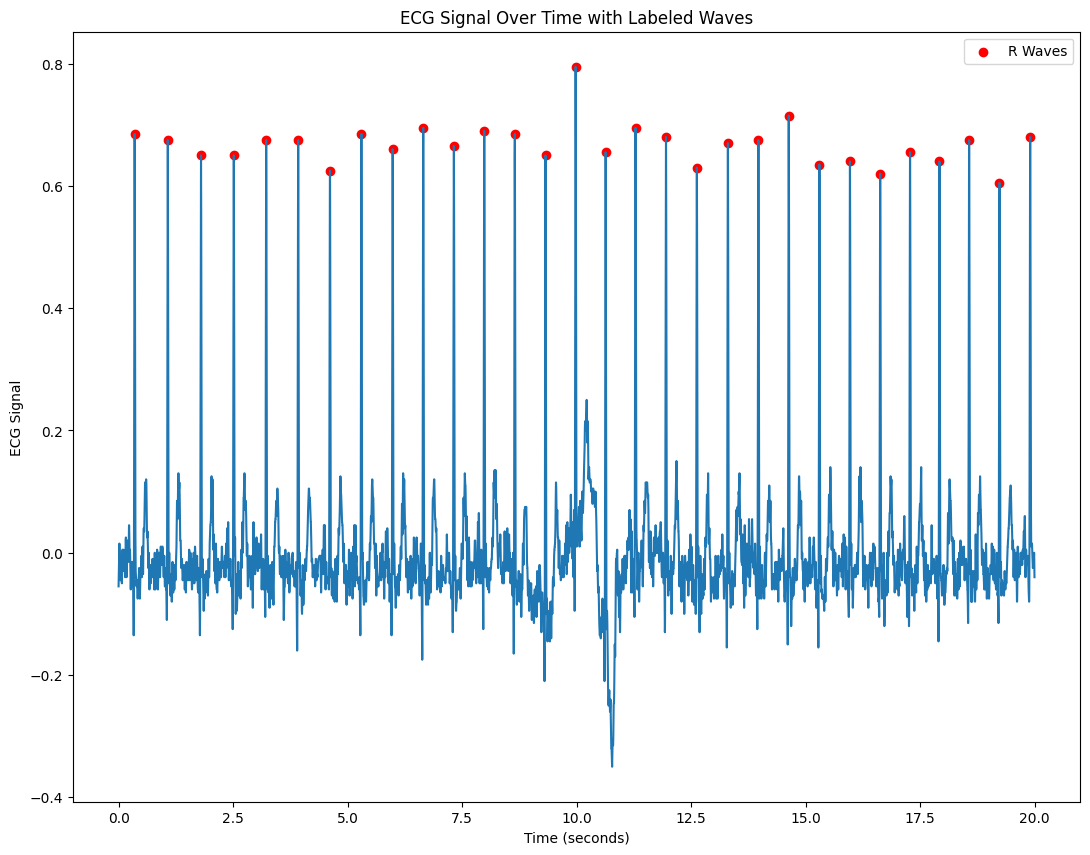

In [64]:
plt.figure(figsize=(13, 10))
plt.plot(time_values, ecg_data)
plt.scatter(waves_df['time'], ecg_data[waves_df['r'].astype(int)], color='red', label='R Waves')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Signal')
plt.title('ECG Signal Over Time with Labeled Waves')
plt.legend()
plt.show()

## Graph the PQST Waves

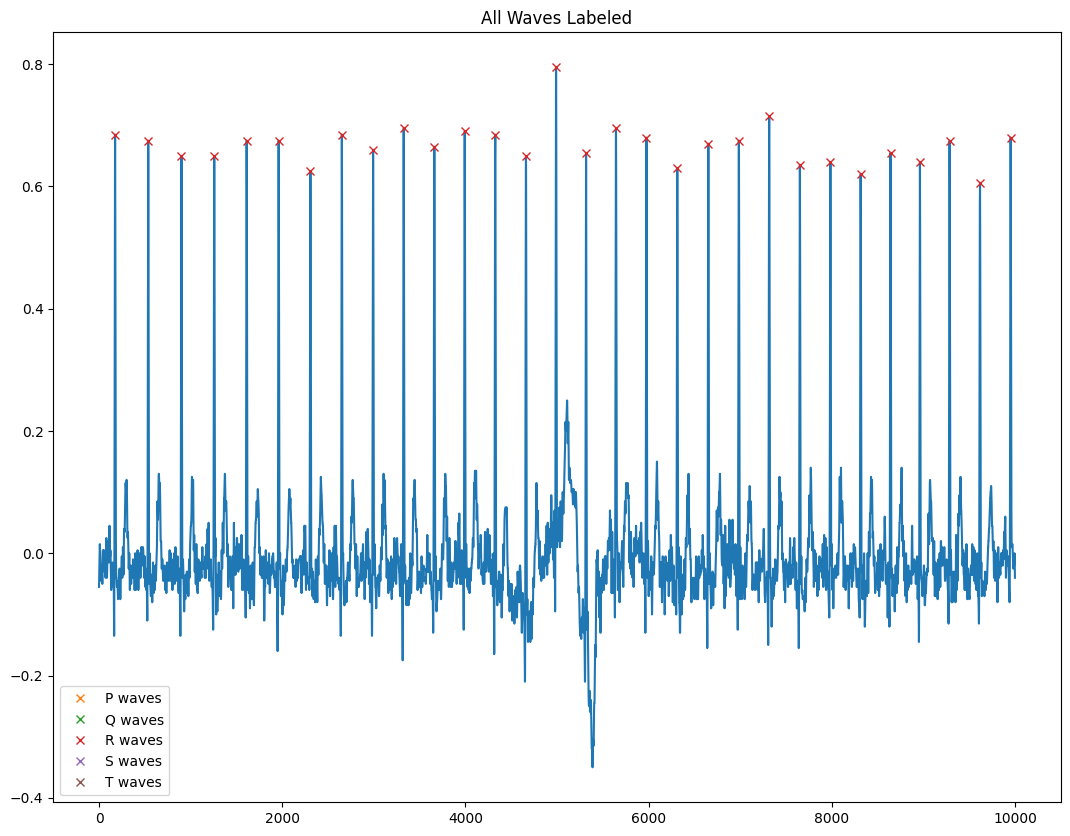

In [56]:
plt.figure(figsize=(13, 10))

pd.Series(ecg_data).plot()
plt.plot(p_waves, ecg_data[p_waves], "x", label="P waves")
plt.plot(q_waves, ecg_data[q_waves], "x", label="Q waves")
plt.plot(r_waves, ecg_data[r_waves], "x", label="R waves")
plt.plot(s_waves, ecg_data[s_waves], "x", label="S waves")
plt.plot(t_waves, ecg_data[t_waves], "x", label="T waves")
plt.legend()
plt.title("All Waves Labeled")
plt.show()